# **Importing Necessary libraries**

* From keras library we are going to use image preprocessing task, to normalize the image pixel values in between 0 to 1.
* Model is imported to load variuos Neural Netwrok models such as Sequential.
* We are going to use transfer learning technique.

In [1]:
import keras
import numpy as np
from keras import Input
from keras import models
from keras import layers
from keras import optimizers
from keras.models import Model
from keras import applications
from keras import backend as k
import matplotlib.pyplot as plt
from keras.optimizers import SGD, Adam
from keras.layers import  Dense, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

2024-06-20 04:24:45.424906: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 04:24:45.424950: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 04:24:45.425750: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-20 04:24:45.431869: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# **Loading the Training and Testing Data and Defining the Basic Parameters**
* We are resizing the input image to 128 * 128

* In the dataset :
    Training Set : 70%
    Validation Set : 20%
    Test Set : 10%

In [2]:
# Normalize training and validation data in the range of 0 to 1
train_datagen = ImageDataGenerator(rescale=1./255) # vertical_flip=True,
                                                   # horizontal_flip=True,
                                                   # height_shift_range=0.1,
                                                   # width_shift_range=0.1
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Read the training sample and set the batch size
train_generator = train_datagen.flow_from_directory(
        '/workspace/USRF/Day5/Data/plant_village/train',
        target_size=(128, 128),
        batch_size=16,
        class_mode='categorical')

# Read Validation data from directory and define target size with batch size
validation_generator = validation_datagen.flow_from_directory(
        '/workspace/USRF/Day5/Data/plant_village/val/',
        target_size=(128, 128),
        batch_size=16,
        class_mode='categorical',
        shuffle=False)

test_generator = test_datagen.flow_from_directory(
        '/workspace/USRF/Day5/Data/plant_village/test/',
        target_size=(128, 128),
        batch_size=1,
        class_mode='categorical',
        shuffle=False)


Found 3002 images belonging to 4 classes.
Found 635 images belonging to 4 classes.
Found 546 images belonging to 4 classes.


# **Visualization of Few Images**

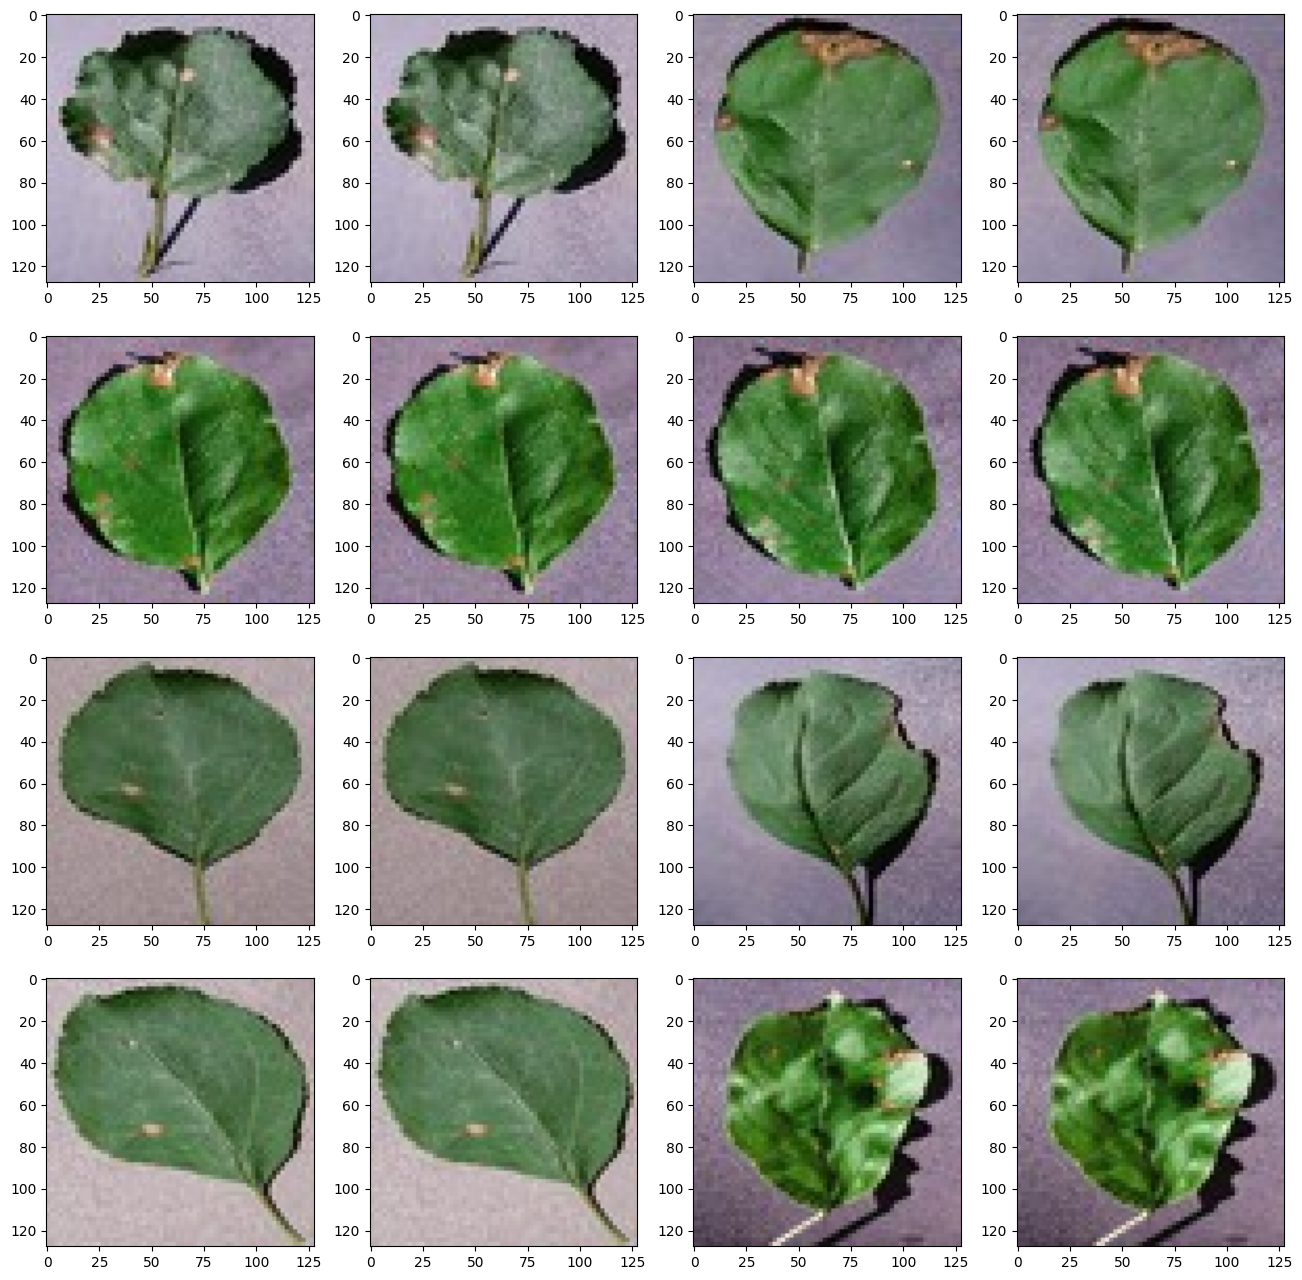

In [3]:
plt.figure(figsize=(16, 16))
for i in range(1, 17):
  plt.subplot(4, 4, i)
  img, label = test_generator.next()
  # print(img.shape)
  # print(label)
  plt.imshow(img[0])
plt.show()

In [5]:
img, label = test_generator.next()
img[0].shape

(128, 128, 3)

# **What is ImageNet?**
ImageNet is formally a project aimed at (manually) labeling and categorizing images into almost 22,000 separate object categories for the purpose of computer vision research.

However, when we hear the term “ImageNet” in the context of deep learning and Convolutional Neural Networks, we are likely referring to the ImageNet Large Scale Visual Recognition Challenge, or ILSVRC for short.

The goal of this image classification challenge is to train a model that can correctly classify an input image into 1,000 separate object categories.

Models are trained on ~1.2 million training images with another 50,000 images for validation and 100,000 images for testing.

# **Exploring Keras Applications for Transfer Learning**

## **VGG16**

In [6]:
from tensorflow.keras.applications.vgg16 import VGG16

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape= (128, 128, 3)) # Include_top = False means excluding the model fully connected layers
base_model.trainable = False ## Not trainable weights

base_model.summary()

2024-06-20 04:25:40.685703: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17947 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 3g.20gb, pci bus id: 0000:b7:00.0, compute capability: 8.0


58889256/58889256 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

# **Adding top layers according to number of classes in our data**

In [7]:
flatten_layer = layers.GlobalAveragePooling2D()
# dense_layer_1 = layers.Dense(63, activation='relu')
# dense_layer_2 = layers.Dense(32, activation='relu')
prediction_layer = layers.Dense(4, activation='softmax')

model = models.Sequential([
    base_model,
    flatten_layer,
    prediction_layer
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 4)                 2052      
                                                                 
Total params: 14716740 (56.14 MB)
Trainable params: 2052 (8.02 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


# **Training**

In [8]:
# sgd = SGD(lr=0.001,decay=1e-6, momentum=0.9, nesterov=True)
# We are going to use accuracy metrics and cross entropy loss as performance parameters
model.compile(optimizer = Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['acc'])
# Train the model
history = model.fit(train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

Epoch 1/30


2024-06-20 04:26:04.102918: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90100
2024-06-20 04:26:05.247786: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f03312fb980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-20 04:26:05.247824: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 3g.20gb, Compute Capability 8.0
2024-06-20 04:26:05.253789: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1718857565.367968  670690 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


187/187 [==============================] - 6s 23ms/step - loss: 0.9814 - acc: 0.6236 - val_loss: 0.7347 - val_acc: 0.8173
Epoch 2/30
187/187 [==============================] - 3s 16ms/step - loss: 0.6468 - acc: 0.8151 - val_loss: 0.5354 - val_acc: 0.8709
Epoch 3/30
187/187 [==============================] - 2s 12ms/step - loss: 0.5023 - acc: 0.8694 - val_loss: 0.4352 - val_acc: 0.9024
Epoch 4/30
187/187 [==============================] - 2s 12ms/step - loss: 0.4183 - acc: 0.8947 - val_loss: 0.3722 - val_acc: 0.9134
Epoch 5/30
187/187 [==============================] - 2s 12ms/step - loss: 0.3657 - acc: 0.9054 - val_loss: 0.3405 - val_acc: 0.9134
Epoch 6/30
187/187 [==============================] - 2s 12ms/step - loss: 0.3270 - acc: 0.9157 - val_loss: 0.3042 - val_acc: 0.9386
Epoch 7/30
187/187 [==============================] - 2s 12ms/step - loss: 0.2996 - acc: 0.9201 - val_loss: 0.2745 - val_acc: 0.9339
Epoch 8/30
187/187 [==============================] - 2s 12ms/step - loss: 0.276

# **Saving the model**

In [9]:
model.save("VGG16_plant_deseas.h5")
print("Saved model to disk")

Saved model to disk


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Loading the model**

In [10]:
model = models.load_model('VGG16_plant_deseas.h5')
print("Model is loaded")

Model is loaded


# **Saving the Weights**

In [11]:
model.save_weights('cnn_classification.h5')

# **Loading the weights**

In [12]:
model.load_weights('cnn_classification.h5')

# **Visualization of training over epoch**

In [13]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

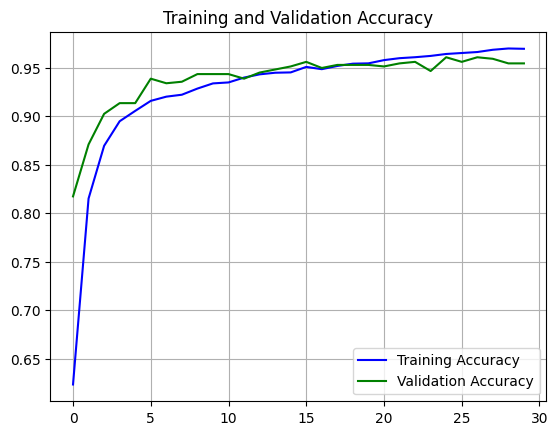

<Figure size 640x480 with 0 Axes>

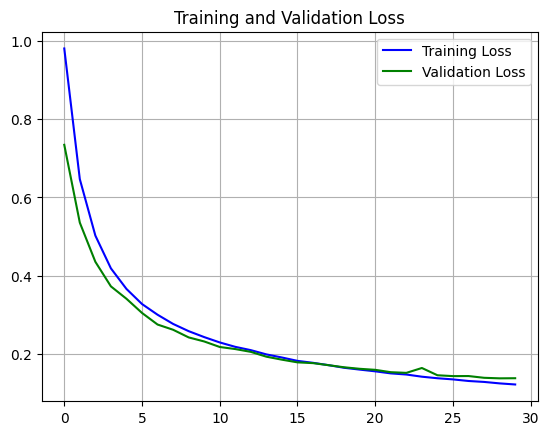

In [14]:
epochs = range(len(train_acc))
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.grid()
plt.legend()
plt.show()

# **Performance measure**

In [15]:
# Get the filenames from the generator
fnames = test_generator.filenames

# Get the ground truth from generator
ground_truth = test_generator.classes

# Get the label to class mapping from the generator
label2index = test_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

# Get the predictions from the model using the generator
predictions = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))


/tmp/ipykernel_669110/461992945.py:14: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size,verbose=1)


546/546 [==============================] - 2s 2ms/step
No of errors = 37/546


In [16]:
accuracy = ((test_generator.samples-len(errors))/test_generator.samples) * 100
accuracy

93.22344322344323

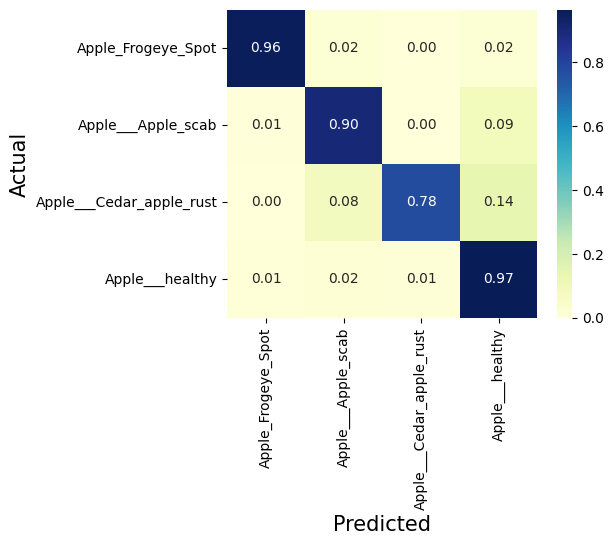

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
cm = confusion_matrix(y_true=ground_truth, y_pred=predicted_classes)
cm = np.array(cm)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=label2index, yticklabels=label2index, cmap="YlGnBu")
plt.ylabel('Actual', fontsize=15)
plt.xlabel('Predicted', fontsize=15)
plt.show(block=False)

In [18]:
from sklearn.metrics import classification_report
print(classification_report(ground_truth, predicted_classes, target_names=label2index))

                          precision    recall  f1-score   support

      Apple_Frogeye_Spot       0.97      0.96      0.97       103
      Apple___Apple_scab       0.92      0.90      0.91       134
Apple___Cedar_apple_rust       0.93      0.78      0.84        49
         Apple___healthy       0.92      0.97      0.94       260

                accuracy                           0.93       546
               macro avg       0.94      0.90      0.92       546
            weighted avg       0.93      0.93      0.93       546



# **InceptionNet**

In [19]:
from keras import applications

## Loading InceptionV3 model
base_model = applications.InceptionV3(weights="imagenet", include_top=False, input_shape= (128, 128, 3))
base_model.trainable = False ## Not trainable weights

base_model.summary()

87910968/87910968 [==============================] - 7s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 63, 63, 32)           864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 63, 63, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activatio

In [20]:
flatten_layer = layers.GlobalAveragePooling2D()
# dense_layer_1 = layers.Dense(63, activation='relu')
# dense_layer_2 = layers.Dense(32, activation='relu')
prediction_layer = layers.Dense(4, activation='softmax')

model = models.Sequential([
    base_model,
    flatten_layer,
    # dense_layer_1,
    # dense_layer_2,
    prediction_layer
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 21810980 (83.20 MB)
Trainable params: 8196 (32.02 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [22]:
model.compile(optimizer = Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['acc'])
# Train the model
history = model.fit(train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

Epoch 1/30
187/187 [==============================] - 5s 15ms/step - loss: 0.0110 - acc: 0.9980 - val_loss: 0.2600 - val_acc: 0.9323
Epoch 2/30
187/187 [==============================] - 2s 11ms/step - loss: 0.0083 - acc: 0.9980 - val_loss: 0.2788 - val_acc: 0.9291
Epoch 3/30
187/187 [==============================] - 2s 10ms/step - loss: 0.0022 - acc: 0.9997 - val_loss: 0.2635 - val_acc: 0.9291
Epoch 4/30
187/187 [==============================] - 2s 10ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.2494 - val_acc: 0.9323
Epoch 5/30
187/187 [==============================] - 2s 10ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.2433 - val_acc: 0.9339
Epoch 6/30
187/187 [==============================] - 2s 11ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.2452 - val_acc: 0.9323
Epoch 7/30
187/187 [==============================] - 2s 10ms/step - loss: 0.0010 - acc: 1.0000 - val_loss: 0.2441 - val_acc: 0.9323
Epoch 8/30
187/187 [==============================] - 2s 10ms/step - 

In [23]:
model.save("InceptionNet_plant_deseas.h5")
print("Saved model to disk")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved model to disk


In [24]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

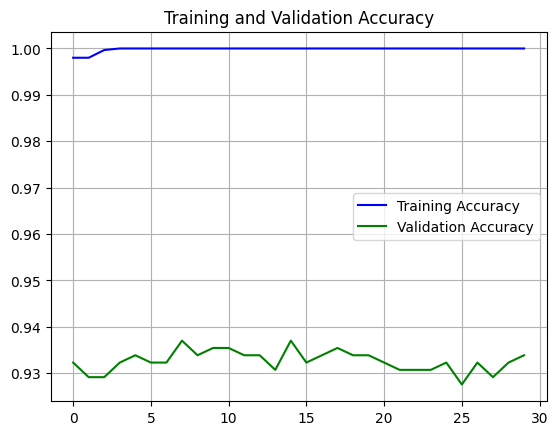

<Figure size 640x480 with 0 Axes>

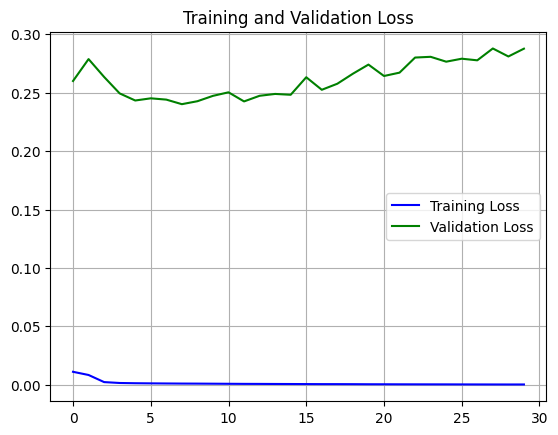

In [25]:
epochs = range(len(train_acc))
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.grid()
plt.legend()
plt.show()

In [26]:
# Get the filenames from the generator
fnames = test_generator.filenames

# Get the ground truth from generator
ground_truth = test_generator.classes

# Get the label to class mapping from the generator
label2index = test_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

# Get the predictions from the model using the generator
predictions = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))


/tmp/ipykernel_669110/461992945.py:14: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size,verbose=1)


546/546 [==============================] - 5s 6ms/step
No of errors = 49/546


In [27]:
accuracy = ((test_generator.samples-len(errors))/test_generator.samples) * 100
accuracy

91.02564102564102

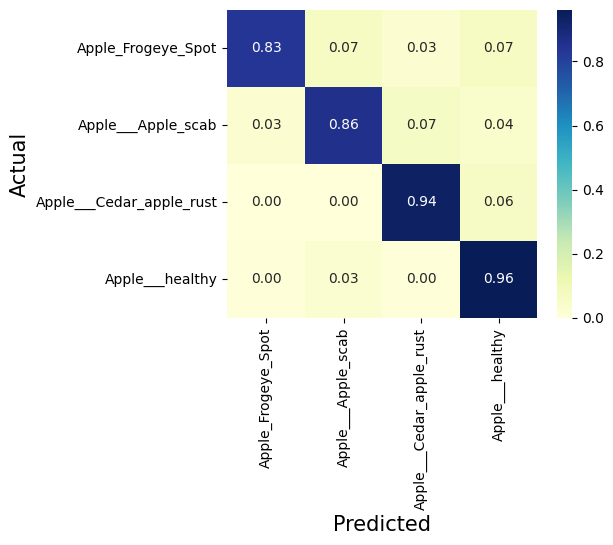

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
cm = confusion_matrix(y_true=ground_truth, y_pred=predicted_classes)
cm = np.array(cm)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=label2index, yticklabels=label2index, cmap="YlGnBu")
plt.ylabel('Actual', fontsize=15)
plt.xlabel('Predicted', fontsize=15)
plt.show(block=False)

In [29]:
from sklearn.metrics import classification_report
print(classification_report(ground_truth, predicted_classes, target_names=label2index))

                          precision    recall  f1-score   support

      Apple_Frogeye_Spot       0.95      0.83      0.89       103
      Apple___Apple_scab       0.88      0.86      0.87       134
Apple___Cedar_apple_rust       0.78      0.94      0.85        49
         Apple___healthy       0.94      0.96      0.95       260

                accuracy                           0.91       546
               macro avg       0.89      0.90      0.89       546
            weighted avg       0.91      0.91      0.91       546



# **ResNet**

In [30]:
from keras import applications

## Loading VGG16 model
base_model = applications.ResNet50(weights="imagenet", include_top=False, input_shape= (128, 128, 3))
base_model.trainable = False ## Not trainable weights

base_model.summary()

94765736/94765736 [==============================] - 7s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                      

In [31]:
flatten_layer = layers.GlobalAveragePooling2D()
# dense_layer_1 = layers.Dense(63, activation='relu')
# dense_layer_2 = layers.Dense(32, activation='relu')
prediction_layer = layers.Dense(4, activation='softmax')

model = models.Sequential([
    base_model,
    flatten_layer,
    # dense_layer_1,
    # dense_layer_2,
    prediction_layer
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 23595908 (90.01 MB)
Trainable params: 8196 (32.02 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [32]:
model.compile(optimizer = Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['acc'])
# Train the model
history = model.fit(train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

Epoch 1/30
187/187 [==============================] - 6s 18ms/step - loss: 1.2508 - acc: 0.4530 - val_loss: 1.1999 - val_acc: 0.5181
Epoch 2/30
187/187 [==============================] - 2s 11ms/step - loss: 1.2202 - acc: 0.4677 - val_loss: 1.1524 - val_acc: 0.5181
Epoch 3/30
187/187 [==============================] - 2s 11ms/step - loss: 1.2036 - acc: 0.4694 - val_loss: 1.1380 - val_acc: 0.5181
Epoch 4/30
187/187 [==============================] - 2s 11ms/step - loss: 1.1845 - acc: 0.4684 - val_loss: 1.1315 - val_acc: 0.5244
Epoch 5/30
187/187 [==============================] - 2s 11ms/step - loss: 1.1699 - acc: 0.4787 - val_loss: 1.1101 - val_acc: 0.5480
Epoch 6/30
187/187 [==============================] - 2s 11ms/step - loss: 1.1544 - acc: 0.4780 - val_loss: 1.0910 - val_acc: 0.5354
Epoch 7/30
187/187 [==============================] - 2s 11ms/step - loss: 1.1429 - acc: 0.4833 - val_loss: 1.0769 - val_acc: 0.5402
Epoch 8/30
187/187 [==============================] - 2s 11ms/step - 

In [33]:
model.save("ResNet_plant_deseas.h5")
print("Saved model to disk")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved model to disk


In [34]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

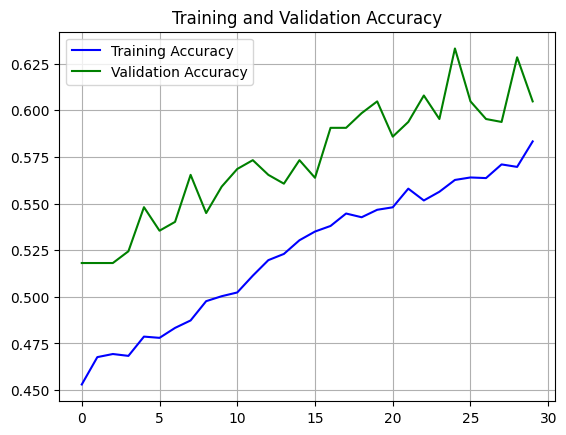

<Figure size 640x480 with 0 Axes>

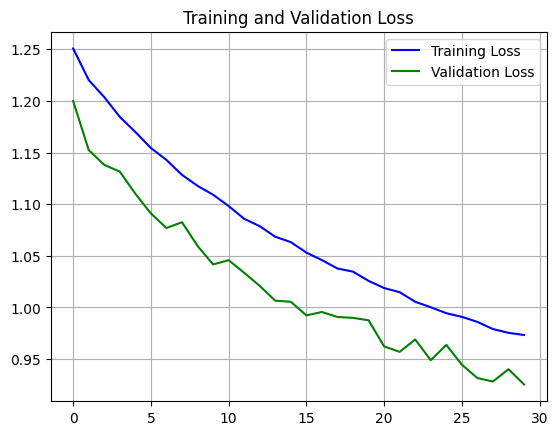

In [35]:
epochs = range(len(train_acc))
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.grid()
plt.legend()
plt.show()

In [36]:
# Get the filenames from the generator
fnames = test_generator.filenames

# Get the ground truth from generator
ground_truth = test_generator.classes

# Get the label to class mapping from the generator
label2index = test_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

# Get the predictions from the model using the generator
predictions = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))


/tmp/ipykernel_669110/461992945.py:14: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size,verbose=1)


546/546 [==============================] - 3s 5ms/step
No of errors = 250/546


In [37]:
accuracy = ((test_generator.samples-len(errors))/test_generator.samples) * 100
accuracy

54.21245421245421

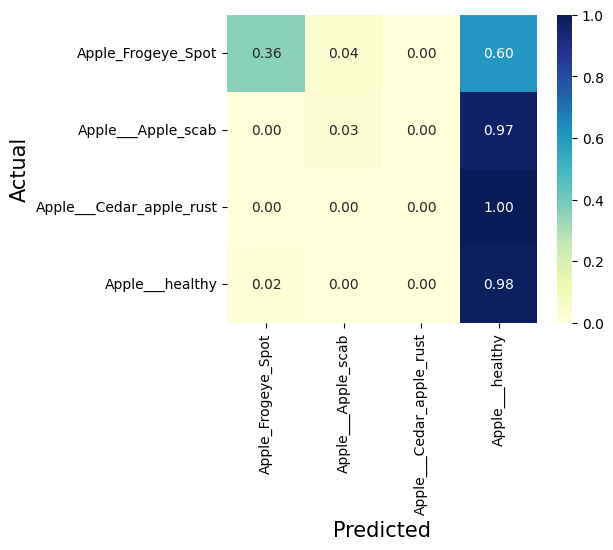

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
cm = confusion_matrix(y_true=ground_truth, y_pred=predicted_classes)
cm = np.array(cm)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=label2index, yticklabels=label2index, cmap="YlGnBu")
plt.ylabel('Actual', fontsize=15)
plt.xlabel('Predicted', fontsize=15)
plt.show(block=False)

In [39]:
from sklearn.metrics import classification_report
print(classification_report(ground_truth, predicted_classes, target_names=label2index))

                          precision    recall  f1-score   support

      Apple_Frogeye_Spot       0.88      0.36      0.51       103
      Apple___Apple_scab       0.50      0.03      0.06       134
Apple___Cedar_apple_rust       0.00      0.00      0.00        49
         Apple___healthy       0.51      0.98      0.67       260

                accuracy                           0.54       546
               macro avg       0.47      0.34      0.31       546
            weighted avg       0.53      0.54      0.43       546



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
